In [41]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [42]:
df= pd.read_csv("../Data/Processed/featured_dataset_V2.csv")

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   acceleration_x           1340 non-null   float64
 1   acceleration_y           1340 non-null   float64
 2   acceleration_z           1340 non-null   float64
 3   temperature_c            1340 non-null   float64
 4   humidity_percent         1340 non-null   float64
 5   wind_speed_mps           1340 non-null   float64
 6   fft_peak_freq            1340 non-null   float64
 7   fft_magnitude            1340 non-null   float64
 8   degradation_score        1340 non-null   float64
 9   structural_condition     1340 non-null   int64  
 10  damage_class             1340 non-null   object 
 11  forecast_score_next_30d  1340 non-null   float64
 12  date                     1340 non-null   object 
 13  time                     1340 non-null   object 
 14  vibration_rms           

In [43]:
def apply_log_transformation(df, features_to_transform):
    for feature in features_to_transform:
        if feature in df.columns:
            # Add a small constant to handle zero or negative values before log transformation
            df[feature] = np.log1p(df[feature] - df[feature].min() + 1e-6) # log1p(x) = log(1+x)
    return df

In [44]:
# Identify numerical features for log transformation. Exclude 'structural_condition' and 'damage_class' as they are target/categorical.
# Also exclude 'timestamp' related columns.
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
features_to_exclude_from_log = ['structural_condition', 'damage_class'] # Exclude target and related scores
features_for_log_transform = [f for f in numerical_features if f not in features_to_exclude_from_log]

# Apply log transformation
df_transformed = apply_log_transformation(df.copy(), features_for_log_transform)

In [45]:
def apply_smote(X, y):
    print(f"Original dataset shape: {X.shape}, Label distribution: {y.value_counts()}")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"Resampled dataset shape: {X_resampled.shape}, Label distribution: {y_resampled.value_counts()}")
    return X_resampled, y_resampled

In [47]:
# Prepare data for SMOTE
# The target variable for SMOTE is 'structural_condition' or 'damage_class'. Let's use 'structural_condition'.
# Features (X) should be numerical and scaled. Target (y) should be categorical.
X = df_transformed.drop(columns=['structural_condition', 'damage_class' ,"date" ,"time"] , axis=1)
y = df_transformed['structural_condition']

#train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , stratify=y)

 # Scale features before SMOTE, as SMOTE works better with scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    

In [48]:

X_scaled_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_scaled_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Apply SMOTE
X_resampled, y_resampled = apply_smote(X_scaled_train_df, y_train)

print("log transformation and SMOTE completed.")
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

# Save the processed data (optional)
X_resampled.to_csv('../Data/Processed/X_resampled.csv', index=False)
y_resampled.to_csv('..//Data/Processed/y_resampled.csv', index=False)

# Display first few rows of processed data for verification
print("\nFirst 5 rows of X_resampled:")
print(X_resampled.head())
print("\nFirst 5 rows of y_resampled:")
print(y_resampled.head())

# Display descriptive statistics of processed data
print("\nDescriptive statistics of X_resampled:")
print(X_resampled.describe())

# Display value counts of the resampled target variable
print("\nValue counts of y_resampled:")
print(y_resampled.value_counts())
  

Original dataset shape: (1072, 19), Label distribution: structural_condition
1    408
2    295
0    293
3     76
Name: count, dtype: int64
Resampled dataset shape: (1632, 19), Label distribution: structural_condition
2    408
1    408
3    408
0    408
Name: count, dtype: int64
log transformation and SMOTE completed.
Shape of X_resampled: (1632, 19)
Shape of y_resampled: (1632,)

First 5 rows of X_resampled:
   acceleration_x  acceleration_y  acceleration_z  temperature_c  \
0        0.521289        0.949216        1.020975       1.342364   
1        1.084826        0.665295       -0.415235      -0.681784   
2        1.132664        0.839244        0.185703      -1.134007   
3        0.300459        0.408330        1.174511       0.238114   
4        1.218640       -1.211254        1.129822       0.298715   

   humidity_percent  wind_speed_mps  fft_peak_freq  fft_magnitude  \
0          0.835751        0.529360      -0.665254      -0.223819   
1          0.323421        0.677149      

In [ ]:
X_test_scaled_df = pd.concat([X_scaled_test_df, y_test] , axis= 1)
X_scaled_test_df.to_csv("../Data/Processed/test_data.csv" , index=False)

In [51]:
import pickle
import joblib

joblib.dump(scaler , "../Data/Processed/scaler.pkl")

['../Data/Processed/scaler.pkl']

<Axes: >

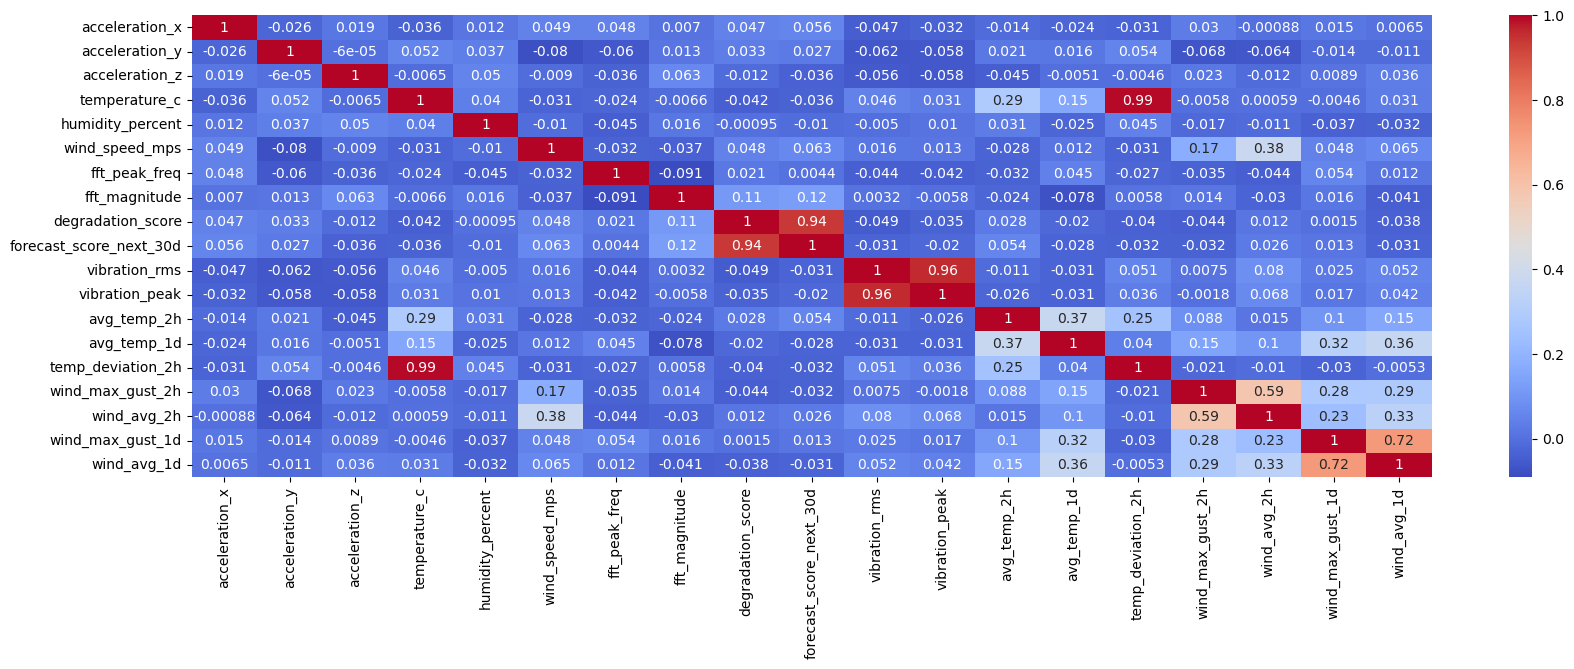

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = X_resampled.corr(numeric_only=True)
plt.figure(figsize = (20,6))
sns.heatmap(corr , annot = True , cmap = "coolwarm")

In [52]:
X_resampled.sample(10)

,acceleration_x,acceleration_y,acceleration_z,temperature_c,humidity_percent,wind_speed_mps,fft_peak_freq,fft_magnitude,degradation_score,forecast_score_next_30d,vibration_rms,vibration_peak,avg_temp_2h,avg_temp_1d,temp_deviation_2h,wind_max_gust_2h,wind_avg_2h,wind_max_gust_1d,wind_avg_1d
1191,0.941764,-0.167079,1.152371,-0.493127,-0.179702,0.738055,0.475353,-0.108286,0.658777,0.681020,0.378625,0.231433,-3.007119,-1.173826,-0.335473,0.566967,0.608089,0.034943,-0.697000
1268,0.271641,-0.853879,0.619522,0.701335,0.590839,-0.218000,0.526449,-0.910270,0.589704,0.658512,-0.354003,-0.530659,0.617114,0.477142,0.663422,-0.353809,-0.111801,0.149598,0.692075
47,-0.856265,-0.442719,0.142224,0.717656,-0.157051,-0.284543,1.291854,-0.506560,0.641406,0.761958,-0.817845,-0.724606,-0.901254,0.091450,0.721535,-0.955426,0.404306,0.031396,0.727152
1122,-0.141988,1.526205,0.535705,-0.582705,0.656406,0.069690,0.943319,-0.425001,-1.550826,-3.285406,0.519122,0.546663,-1.200288,-0.866897,-0.464418,0.213174,0.992959,-0.118013,-0.496228
857,-1.497853,1.419246,1.059835,-0.358771,-2.730795,1.034439,0.193382,-1.077862,-3.184519,-3.844259,1.133134,0.329439,0.105541,-0.208403,-0.328182,0.257617,0.506432,-0.343255,-0.714349
1044,-1.554632,0.732912,-0.938444,0.457463,-0.154976,-0.785289,0.604164,-1.271952,0.883343,0.863500,0.493015,0.308667,-0.539484,-1.094930,0.576127,-2.308644,-1.600640,-0.173735,-0.840786
517,0.227086,0.271184,-0.168592,-0.133599,-1.145634,0.504186,0.935797,-1.079911,-0.324506,-0.537438,-2.148644,-2.108505,0.116241,0.786181,-0.235701,0.280334,-1.408193,0.200710,-0.360310
1035,1.160593,2.327355,0.684627,0.027289,0.784007,-1.567052,1.231089,1.071336,0.137626,0.079074,1.929428,2.104095,0.067723,-0.385389,0.079720,-0.767346,-0.524002,-0.202461,-0.256478
1515,0.107772,0.942691,-1.063883,0.319611,0.712603,1.064196,-0.972711,0.833005,1.092945,1.110792,-0.192770,-0.392000,0.618104,0.835380,0.229789,0.339984,-0.029848,0.125094,0.301453
1151,0.362078,-0.151210,0.561673,-0.048071,-0.609161,-0.477246,0.911473,1.345207,-0.470227,-0.425729,-1.406135,-1.300239,-1.292312,-0.232751,-0.021388,0.630040,0.716763,0.062941,0.473834


In [63]:
y_resampled.head()

0    2
1    2
2    2
3    1
4    2
Name: structural_condition, dtype: int64